 June 2021 heatwave (June 27 - June 30)
 - a map showing  maximum or minimum temperature over all days (with add_basemap)  
 - create the shapefile data 

In [1]:
# Mask PRISM data with shapefile

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from importlib import reload
from shapely.geometry import Point, Polygon
from rasterio import features
from affine import Affine
import geoplot as gplt
from importlib import reload
# import image module
from IPython.display import Image

# in a Jupyter notebook: “magic” command to render plots properly:
%matplotlib inline

import innovator_func
reload(innovator_func)
from innovator_func import transform_from_latlon
from innovator_func import rasterize
from innovator_func import add_shape_coord_from_data_array
from innovator_func import create_shape_2d

In [2]:
dir_o = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/PLOT/'
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'

####  geospatial plot
Because of high resolution shapefile, there is no PRISM grid inside a lot of shapes. I calculate the centroid of those polygons and then use the nearest prism grid data

In [3]:
flnm_shp = '/glade/work/mingge/SHAPEFILES/counties.shp'
flnm_shp = '/glade/work/mingge/SHAPEFILES/ncar_oregon_area/ncar_oregon.shp'
flnm_shp = '/glade/work/mingge/SHAPEFILES/COUNTY_OREGON/sovi_3county_SD/sovi_3_county.shp'
shp_gpd = gpd.read_file(flnm_shp)

crs={'init':'epsg:4326'}
#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

# Get lat-lon of geodataframe polygon, and then add them back
# I use centroid of the shape
#  reproject geodataframe to a geographic CRS, e.g EPSG:4326 
# nc_counties = shp_gpd.to_crs(4326)
#shp_gpd = shp_gpd.set_crs('EPSG:4326')
shp_gpd['lon_centroid'] = shp_gpd.centroid.x  
shp_gpd['lat_centroid'] = shp_gpd.centroid.y

n_shp = len(shp_gpd.centroid)

/glade/scratch/mingge/ipykernel_122685/3635624041.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lon_centroid'] = shp_gpd.centroid.x
/glade/scratch/mingge/ipykernel_122685/3635624041.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lat_centroid'] = shp_gpd.centroid.y
/glade/scratch/mingge/ipykernel_122685/3635624041.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  n_shp = len(shp_gpd.centroid)


#### June 2021 heatwave (June 27 - June 30)

In [4]:
date_st = '2021-06-27'
date_end = '2021-06-30'
date_s = pd.date_range(date_st, date_end, freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

var_s = 'Tmax'  # 'Tmin' or 'Tmax'

flnm = dir_prism + var_s + '/PRISM_daily_'+var_s.lower()+'_2021.nc'
ds = xr.open_dataset(flnm)
tmax_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82))[var_s]
 
flnm
#minumum temperature (maximum over all days of the heatwave event).
#tmax_2d = tmax_3d.min(dim='time' )

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'cfgrib.messages' has no attribute 'DEFAULT_INDEXPATH'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


'/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmax/PRISM_daily_tmax_2021.nc'

In [5]:
n_day = len(tmax_3d)
tmin_1d = np.zeros((n_shp))
for nd in range(n_day):
    var_ss = var_s.lower() + '_' + str(date_s[nd])
    print(var_ss)
    for nn in range(n_shp):
        lat_0 = shp_gpd['lat_centroid'][nn]
        lon_0 = shp_gpd['lon_centroid'][nn]
        t = tmax_3d[nd].sel(rlon=lon_0, rlat=lat_0, method="nearest")
        tmin_1d[nn]=t.values
        
    shp_gpd[var_ss] = tmin_1d  

tmax_20210627
tmax_20210628
tmax_20210629
tmax_20210630


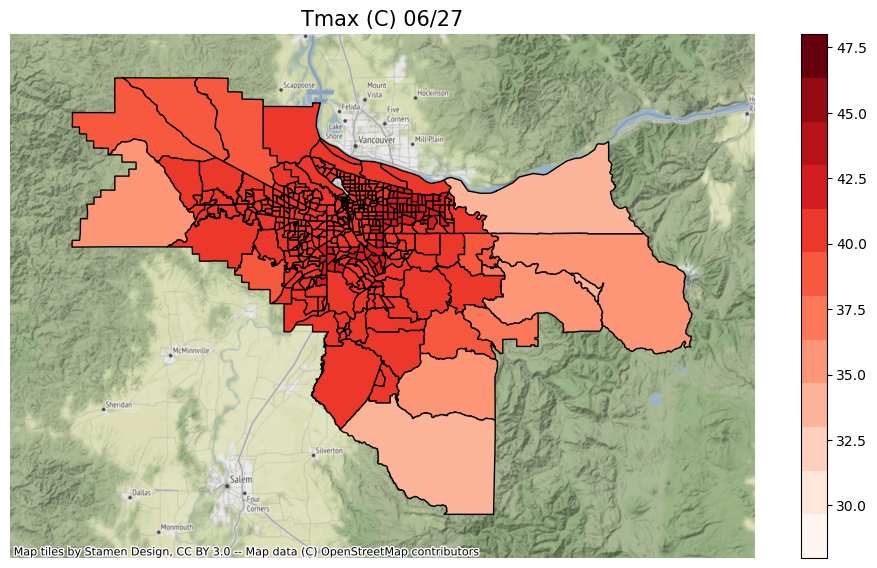

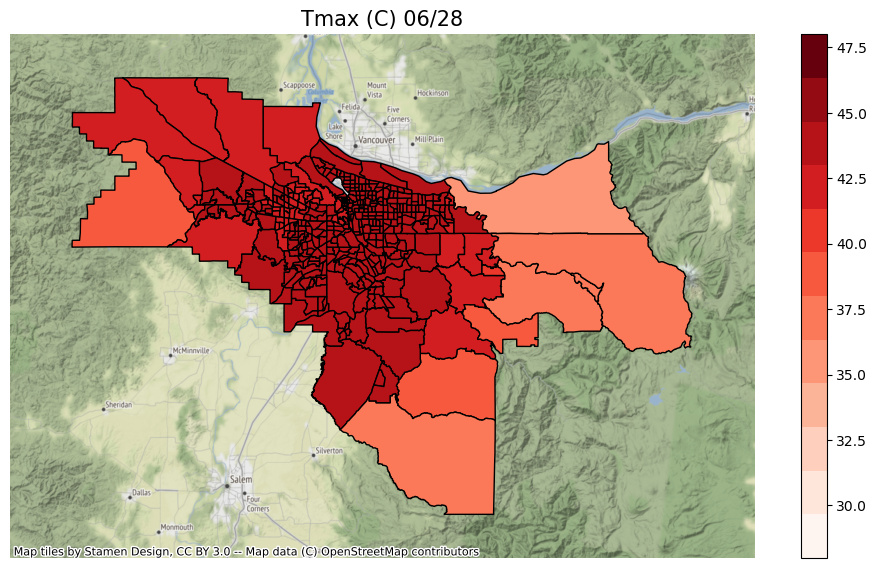

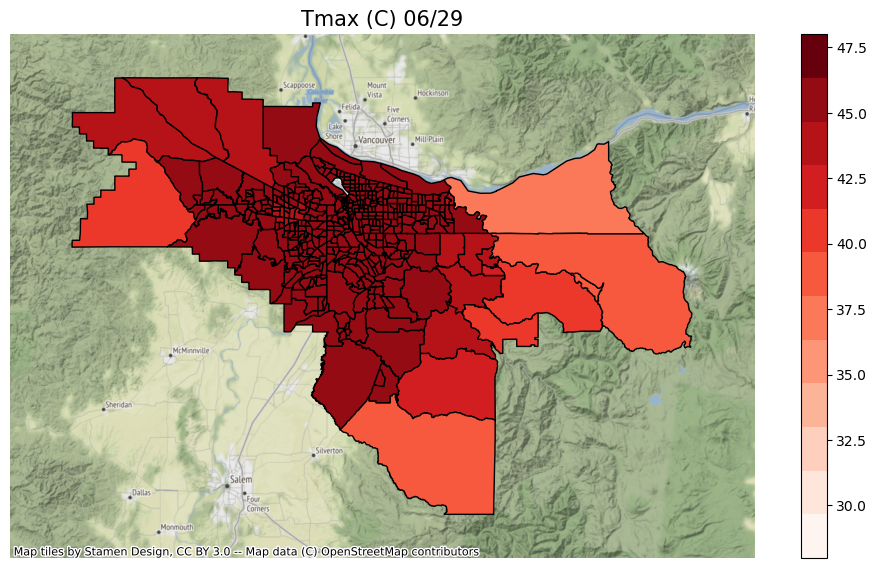

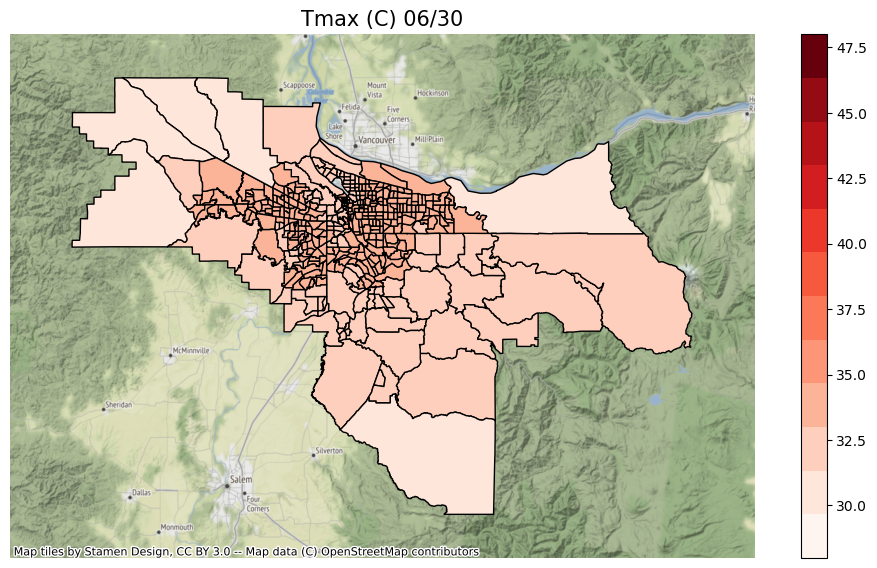

In [12]:
import contextily as cx

if var_s == 'Tmax':
    vmin = 28
    vmax = 48
elif var_s == 'Tmin':
    vmin = 12
    vmax = 24
    
for day in range(27,31):
    ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
    cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
    ax.set_title(var_s + ' (C) 06/' + str(day), size = 15)
    shp_gpd.plot(ax=ax, column=var_s.lower() + '_202106' +str(day), edgecolor="black",
             vmin=vmin, vmax=vmax,
             cmap = plt.cm.get_cmap('Reds', 12),
             legend=True,legend_kwds={"shrink":.85})  
    plt.show()
#plt.savefig(dir_o + 'tmin_heatwave_2021_new.png', bbox_inches='tight')

#### in future senario
according to Sixth Oregon Climate Assessment of Erica Fleishman table 1 and 2
I want two tables side by side, instead of using
Image(url="t_future_change.png", width=300, height=300)

<table><tr>
<td> <img src="t_future_change.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="prec_future_change.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

 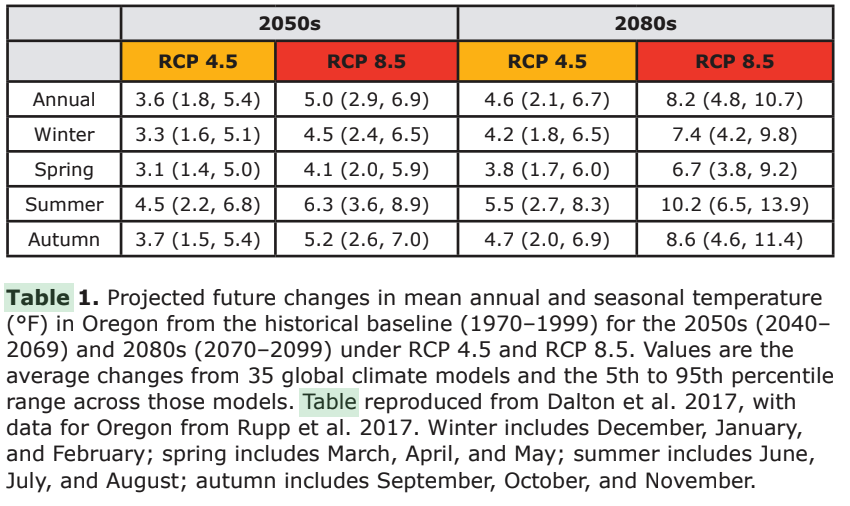
 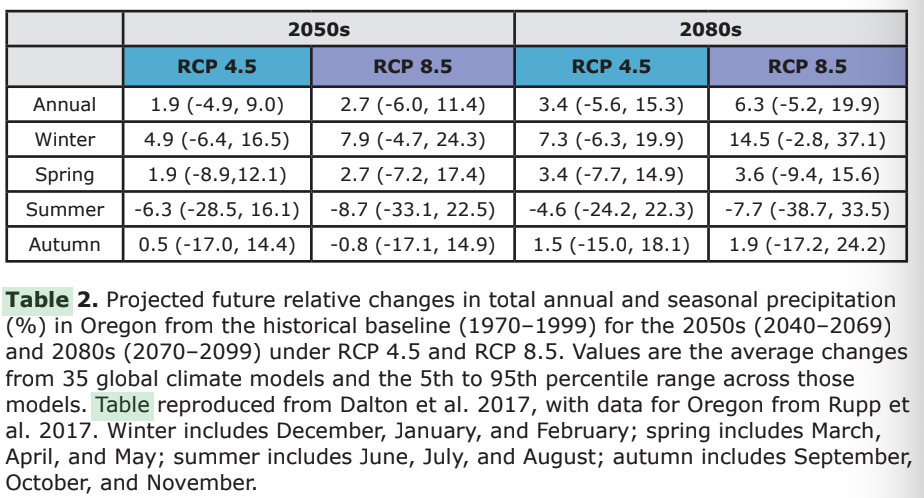

In [14]:
# 2121 summer head wave case adjustment
dt_2050s_RCP45_summer = (2055-2021)/(2055-1985)*4.5*5/9
dt_2050s_RCP85_summer = (2055-2021)/(2055-1985)*6.3*5/9

dt_2080s_RCP45_summer = (2085-2021)/(2085-1985)*5.5*5/9
dt_2080s_RCP85_summer = (2085-2021)/(2085-1985)*10.2*5/9

dt_1d = [dt_2050s_RCP45_summer, dt_2050s_RCP85_summer, dt_2080s_RCP45_summer, dt_2080s_RCP85_summer]
scen_1d =['2050s_RCP45', '2050s_RCP85', '2080s_RCP45', '2080s_RCP85'] 
n_scen = len(scen_1d)

tmax_20210627_2050s_RCP45
tmax_20210628_2050s_RCP45
tmax_20210629_2050s_RCP45
tmax_20210630_2050s_RCP45
tmax_20210627_2050s_RCP85
tmax_20210628_2050s_RCP85
tmax_20210629_2050s_RCP85
tmax_20210630_2050s_RCP85
tmax_20210627_2080s_RCP45
tmax_20210628_2080s_RCP45
tmax_20210629_2080s_RCP45
tmax_20210630_2080s_RCP45
tmax_20210627_2080s_RCP85
tmax_20210628_2080s_RCP85
tmax_20210629_2080s_RCP85
tmax_20210630_2080s_RCP85


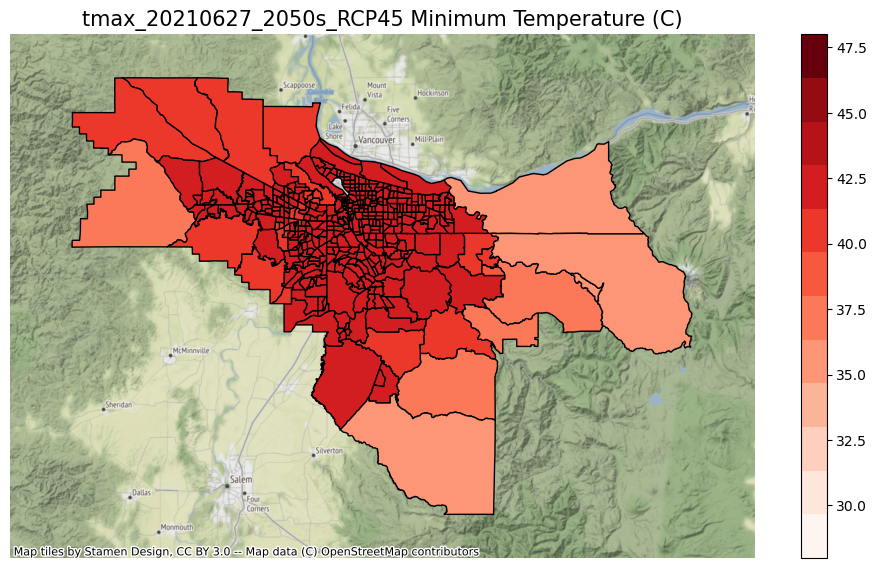

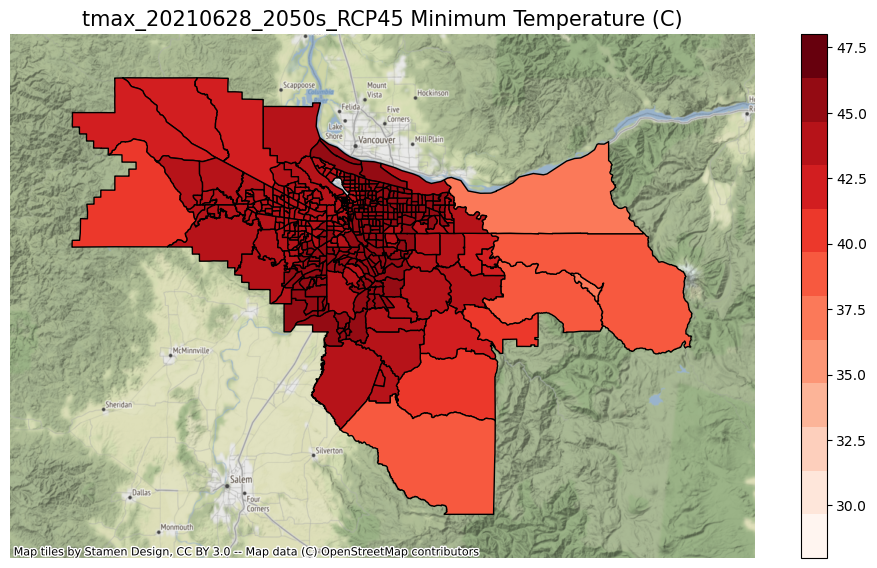

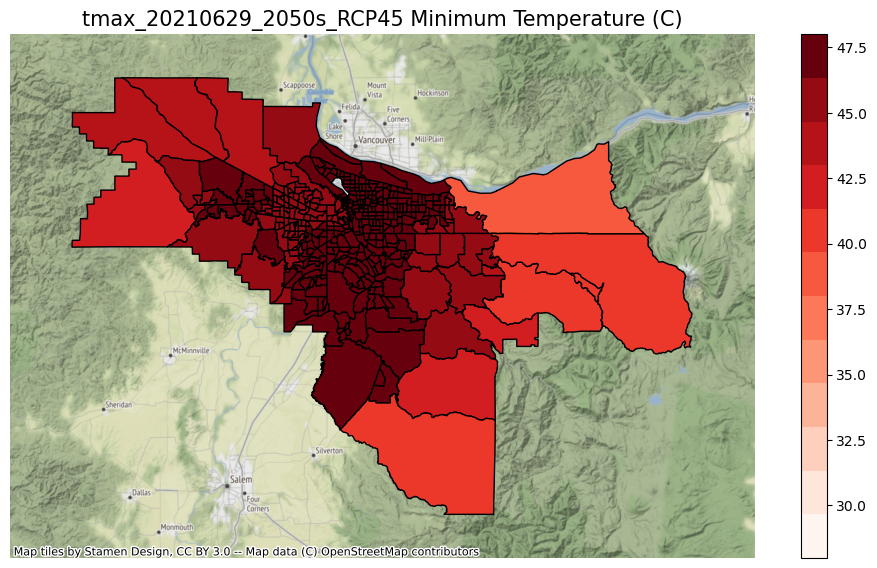

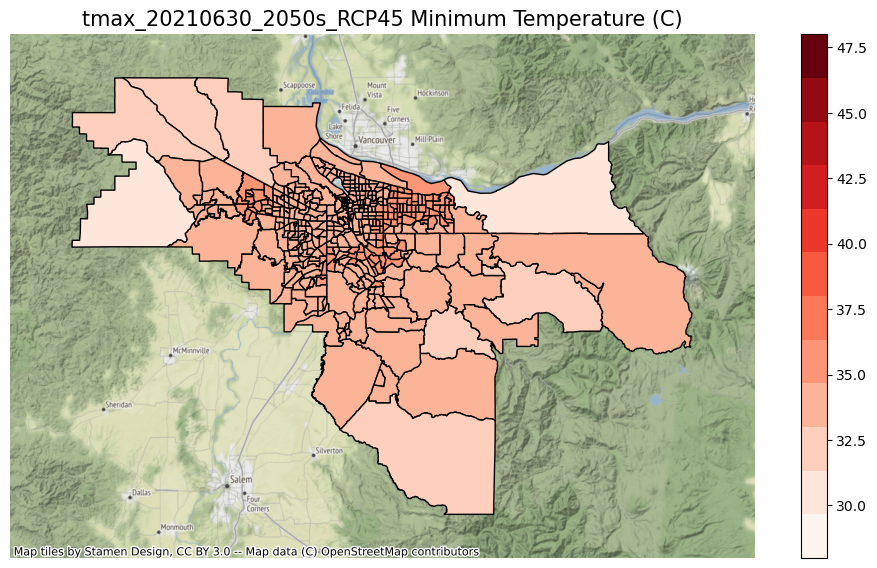

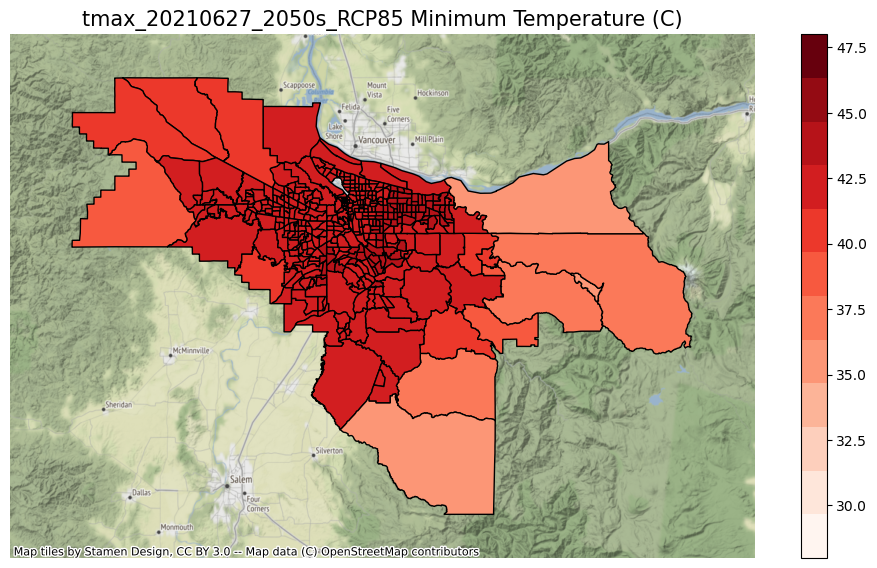

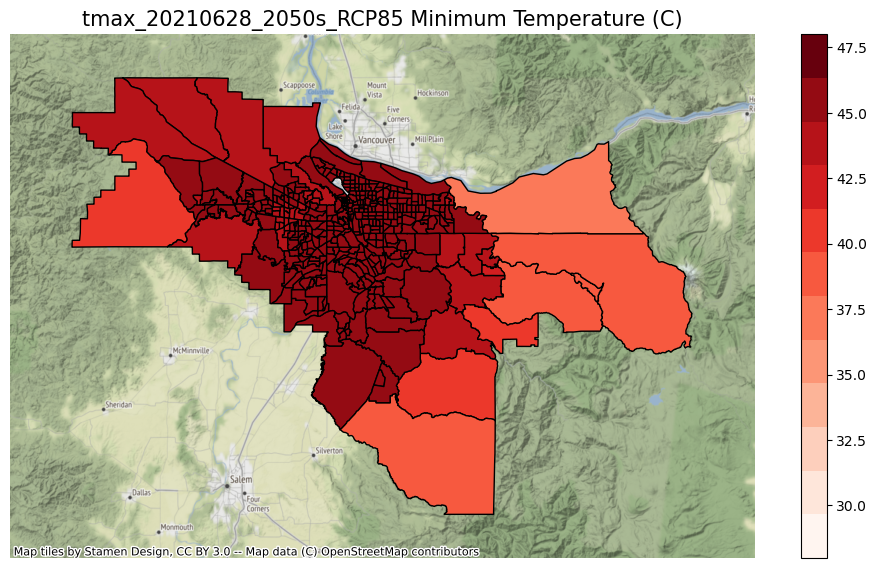

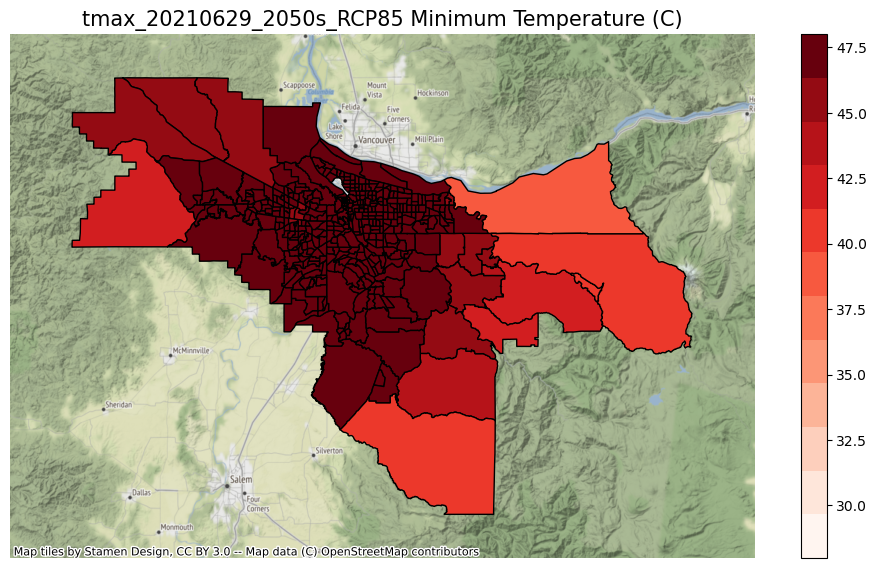

In [ ]:
n_day = len(tmax_3d)
tmin_1d = np.zeros((n_shp))

for ns in range(n_scen): 
    for nd in range(n_day):        
        var_new  = var_s.lower() + '_' + str(date_s[nd]) + '_' + scen_1d[ns]
        print(var_new)
        for nn in range(n_shp):
            lat_0 = shp_gpd['lat_centroid'][nn]
            lon_0 = shp_gpd['lon_centroid'][nn]
            t = tmax_3d[nd].sel(rlon=lon_0, rlat=lat_0, method="nearest")
            tmin_1d[nn]=t.values + dt_1d[ns]
            #print(tmin_1d[nn])
        
        shp_gpd[var_new] = tmin_1d  
    
        ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
        cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
        ax.set_title(var_new + ' Minimum Temperature (C)', size = 15)
        shp_gpd.plot(ax=ax, column=var_new, edgecolor="black",
             vmin=vmin, vmax=vmax,
             cmap = plt.cm.get_cmap('Reds', 12),
             legend=True,legend_kwds={"shrink":.85})

In [30]:
flnm_o = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/'+ var_s.lower() + "_current_future.shp"
print('output:' + flnm_o)
shp_gpd.to_file(flnm_o)
 

output:/glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/tmax_current_future.shp


/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/glade/scratch/mingge/ipykernel_121633/862399420.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gpd.to_file(flnm_o)


In [31]:
shp_gpd.head
shp_gpd.iloc[:, -20:]

tmax_20210627  tmax_20210628  tmax_20210629  tmax_20210630  \
0        40.310101      43.454899      45.240398      32.552799   
1        40.940899      43.691998      45.499897      32.993099   
2        40.661198      43.534798      45.355400      32.752300   
3        40.785999      43.618099      45.401897      32.860298   
4        40.766701      43.610897      45.423397      32.635201   
..             ...            ...            ...            ...   
411      41.615398      43.622898      45.384800      33.816498   
412      40.824600      43.448200      45.386799      32.966499   
413      41.201401      43.948997      45.742500      33.279198   
414      41.479797      44.204399      45.972000      33.458900   
415      41.201401      43.948997      45.742500      33.279198   

     tmax_20210627_2050s_RCP45  tmax_20210628_2050s_RCP45  \
0                    41.524386                  44.669185   
1                    42.155185                  44.906283   
2                    41.875483                  44.749083   
3                    42.000285                  44.832385   
4                    41.980986                  44.825183   
..                         ...                        ...   
411                  42.829684                  44.837184   
412                  42.038886                  44.662486   
413                  42.415686                  45.163283   
414                  42.694083                  45.418685   
415                  42.415686                  45.163283   

     tmax_20210629_2050s_RCP45  tmax_20210630_2050s_RCP45  \
0                    46.454684                  33.767085   
1                    46.714183                  34.207385   
2                    46.569686                  33.966586   
3                    46.616183                  34.074584   
4                    46.637683                  33.849486   
..                         ...                        ...   
411                  46.599086                  35.030784   
412                  46.601085                  34.180785   
413                  46.956786                  34.493483   
414                  47.186286                  34.673186   
415                  46.956786                  34.493483   

     tmax_20210627_2050s_RCP85  tmax_20210628_2050s_RCP85  \
0                    42.010101                  45.154899   
1                    42.640899                  45.391998   
2                    42.361198                  45.234798   
3                    42.485999                  45.318099   
4                    42.466701                  45.310897   
..                         ...                        ...   
411                  43.315398                  45.322898   
412                  42.524600                  45.148200   
413                  42.901401                  45.648997   
414                  43.179797                  45.904399   
415                  42.901401                  45.648997   

     tmax_20210629_2050s_RCP85  tmax_20210630_2050s_RCP85  \
0                    46.940398                  34.252799   
1                    47.199897                  34.693099   
2                    47.055400                  34.452300   
3                    47.101897                  34.560298   
4                    47.123397                  34.335201   
..                         ...                        ...   
411                  47.084800                  35.516498   
412                  47.086799                  34.666499   
413                  47.442500                  34.979198   
414                  47.672000                  35.158900   
415                  47.442500                  34.979198   

     tmax_20210627_2080s_RCP45  tmax_20210628_2080s_RCP45  \
0                    42.265656                  45.410454   
1                    42.896454                  45.647553   
2                    42.616753                  45.490353   
3                    42.